In [1]:
import pybaseball as pyb
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

# Pitch Value

In [2]:
mlb_21=pd.read_csv('mlb_21.csv')

In [3]:
data_21 = mlb_21[['pitch_type', 'game_date', 'release_speed', 'release_pos_x',
       'release_pos_z', 'release_pos_y', 'player_name', 'batter', 'pitcher', 'events', 'description', 'zone',
       'game_type', 'stand', 'p_throws', 'home_team', 'away_team', 'type',
       'hit_location', 'bb_type', 'balls', 'strikes', 'game_year', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'on_3b', 'on_2b', 'on_1b',
       'outs_when_up', 'inning', 'inning_topbot', 'hc_x', 'hc_y', 'launch_speed', 'launch_angle', 'release_spin_rate', 'release_extension', 'game_pk',
       'woba_value', 'launch_speed_angle', 'at_bat_number', 'pitch_number', 'pitch_name', 'home_score', 'away_score', 'post_away_score', 'post_home_score',
       'bat_score', 'post_bat_score', 'fld_score', 'delta_home_win_exp', 'delta_run_exp']]

data_21['1b'] = np.where(data_21['on_1b'].notnull(), 1, 0)
data_21['2b'] = np.where(data_21['on_2b'].notnull(), 1, 0)
data_21['3b'] = np.where(data_21['on_3b'].notnull(), 1, 0)
data_21 = data_21.sort_values(by=['game_pk', 'at_bat_number', 'pitch_number'])
data_21['start_state'] = data_21['1b'].astype('str') + data_21['2b'].astype('str') + data_21['3b'].astype('str') + ' ' + data_21['outs_when_up'].astype('str')
data_21['next_state'] = data_21['start_state'].shift(-1)
data_21['next_topbot'] = data_21['inning_topbot'].shift(-1)
data_21['next_game_pk'] = data_21['game_pk'].shift(-1)
data_21['next_state'] = np.where((data_21['inning_topbot']!=data_21['next_topbot'])|
                                 (data_21['next_game_pk']!=data_21['game_pk'])|
                                 (data_21['next_state'].isnull()), '000 3', data_21['next_state'])

data_21['scoring'] = data_21['post_bat_score'] - data_21['bat_score']
score = data_21.groupby(['game_pk', 'inning', 'inning_topbot'])['bat_score'].max().reset_index().rename(columns={'bat_score': 'inning_score'})
data_21 = pd.merge(data_21, score, on=['game_pk', 'inning', 'inning_topbot'])

In [4]:
events = data_21[data_21['events'].notnull()]
events['future_run'] = events['inning_score'] - events['bat_score']
re = events.groupby('start_state')['future_run'].mean().reset_index().rename(columns={'future_run': 're'})
re_0003 = pd.DataFrame([['000 3', 0]], columns=['start_state', 're'])
re = re.append(re_0003)
data_21 = pd.merge(data_21, re, on=['start_state'])
events = pd.merge(events, re, on=['start_state'])

In [5]:
next_re = re.copy().rename(columns={'start_state': 'next_state', 're': 'next_re'})
data_21 = pd.merge(data_21, next_re, on=['next_state'])
data_21 = data_21.sort_values(by=['game_pk', 'at_bat_number', 'pitch_number'])
events = pd.merge(events, next_re, on=['next_state'])

In [6]:
events['run_value'] = events['next_re'].astype('float') - events['re'].astype('float') + events['post_bat_score'].astype('float') - events['bat_score'].astype('float')
at_bat_rv = events[['game_pk', 'at_bat_number', 'run_value']]
data_21 = pd.merge(data_21, at_bat_rv, on=['game_pk', 'at_bat_number'])
event_rv = data_21.groupby('events')['run_value'].mean().reset_index().sort_values(by='run_value', ascending=False).rename(columns={'run_value': 'event_rv'})

In [7]:
data_21 = pd.merge(data_21, event_rv, on='events', how='left')
data_21['count'] = data_21['balls'].astype('str')+'-'+data_21['strikes'].astype('str')
data_21 = data_21[data_21['balls']!=4]
rv_by_count = data_21.groupby(['count'])['run_value'].mean().reset_index().rename(columns={'run_value': 'count_rv'})

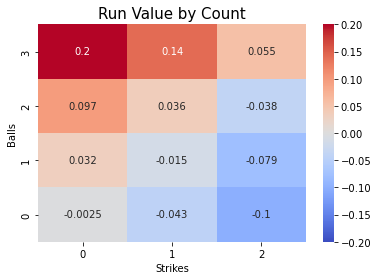

In [29]:
table1 = pd.DataFrame(np.array([rv_by_count['count_rv'][0:3], rv_by_count['count_rv'][3:6], rv_by_count['count_rv'][6:9], rv_by_count['count_rv'][9:12]]),
            columns=['0','1','2'], index=['0','1','2','3'], dtype='float')

sns.heatmap(table1.iloc[::-1], annot=True, cmap='coolwarm', vmin=-0.2, vmax=0.2)
plt.title("Run Value by Count", size=15)
plt.xlabel('Strikes')
plt.ylabel('Balls')
plt.show()

In [9]:
data_21 = pd.merge(data_21, rv_by_count, on='count')
data_21 = data_21.sort_values(by=['game_pk', 'at_bat_number', 'pitch_number'])
data_21['next_count_rv'] = data_21['count_rv'].shift(-1)
data_21['next_count_rv'] = np.where(data_21['events'].isnull(), data_21['next_count_rv'], data_21['event_rv'])

data_21['pitch_value'] = data_21['next_count_rv'] - data_21['count_rv']


In [11]:
starter = np.array(data_21[data_21['inning']==1]['player_name'].unique())
starter_data = data_21[data_21['player_name'].isin(starter)]

In [64]:
starter_pv = starter_data.groupby(['game_date', 'player_name', 'pitch_name']).agg({'pitch_value': 'sum', 'release_speed': 'mean', 'pitcher': 'count'}).reset_index().rename(columns={'pitcher': 'count', 'pitch_value': 'pitch_value_sum'})
starter_pv_mean = starter_data.groupby(['player_name', 'pitch_name']).agg({'pitch_value': 'mean'}).reset_index().rename(columns={'pitch_value': 'pitch_value_mean'})
starter_pv = pd.merge(starter_pv, starter_pv_mean, on=['player_name', 'pitch_name'])
starter_pv['pitch_value_sum'] = round(starter_pv['pitch_value_sum'],4)
starter_pv['pitch_value_mean'] = round(starter_pv['pitch_value_mean'],4)
starter_pv['release_speed'] = round(starter_pv['release_speed'],2)


starter_total = starter_pv.groupby(['player_name'])['count'].sum().reset_index().rename(columns={'count': 'total'})
starter_pv=pd.merge(starter_pv, starter_total, on ='player_name')
starter_pv['pitch %'] = round(100*starter_pv['count']/starter_pv['total'],1)
starter_pv = starter_pv[['player_name', 'pitch_name', 'pitch_value_sum', 'pitch_value_mean', 'release_speed', 'count', 'total', 'pitch %']]

starter_pv[(starter_pv['pitch_name']=='4-Seam Fastball')&(starter_pv['count']>=600)].sort_values(by='pitch_value_mean').head(10).reset_index().drop('index', axis=1)

,player_name,pitch_name,pitch_value_sum,pitch_value_mean,release_speed,count,total,pitch %
0,"deGrom, Jacob",4-Seam Fastball,-16.7705,-0.0238,99.21,704,1226,57.4
1,"Glasnow, Tyler",4-Seam Fastball,-12.8647,-0.0186,96.99,691,1339,51.6
2,"Rasmussen, Drew",4-Seam Fastball,-13.2918,-0.0171,97.08,779,1198,65.0
3,"Steckenrider, Drew",4-Seam Fastball,-11.2558,-0.0170,94.04,663,1005,66.0
4,"Rodón, Carlos",4-Seam Fastball,-21.9179,-0.0168,95.36,1302,2219,58.7
5,"Lynn, Lance",4-Seam Fastball,-16.9944,-0.0162,93.99,1049,2500,42.0
6,"Peralta, Freddy",4-Seam Fastball,-19.0718,-0.0157,93.38,1216,2356,51.6
7,"Bauer, Trevor",4-Seam Fastball,-9.9521,-0.0138,93.86,719,1787,40.2
8,"Scherzer, Max",4-Seam Fastball,-18.0052,-0.0137,94.30,1316,2821,46.7
9,"Wheeler, Zack",4-Seam Fastball,-16.2551,-0.0120,97.17,1360,3205,42.4


In [44]:
starter_pv[(starter_pv['pitch_name']=='Sinker')&(starter_pv['count']>=500)].sort_values(by='pitch_value_sum').head(10).reset_index().drop('index', axis=1)

,player_name,pitch_name,pitch_value_sum,release_speed,count,total,pitch %
0,"Houser, Adrian",Sinker,-24.5965,93.57,1266,2352,53.8
1,"Wainwright, Adam",Sinker,-17.5202,89.05,861,3066,28.1
2,"Suárez, Ranger",Sinker,-17.3642,92.94,734,1614,45.5
3,"Alcantara, Sandy",Sinker,-15.4028,97.62,872,3090,28.2
4,"Webb, Logan",Sinker,-13.7604,92.78,834,2214,37.7
5,"Berríos, José",Sinker,-13.5082,93.82,899,3039,29.6
6,"Woodruff, Brandon",Sinker,-13.1461,96.25,751,2810,26.7
7,"Bassitt, Chris",Sinker,-12.8081,92.74,850,2379,35.7
8,"Wheeler, Zack",Sinker,-10.7557,96.71,582,3205,18.2
9,"Dunning, Dane",Sinker,-8.6105,90.37,996,1909,52.2


In [71]:
starter_pv[(starter_pv['pitch_name']=='Cutter')&(starter_pv['count']>=300)].sort_values(by='pitch_value_mean').head(20).reset_index().drop('index', axis=1)

,player_name,pitch_name,pitch_value_sum,pitch_value_mean,release_speed,count,total,pitch %
0,"Civale, Aaron",Cutter,-15.1528,-0.0318,87.72,476,1909,24.9
1,"Thompson, Zach",Cutter,-12.0145,-0.0287,87.06,419,1193,35.1
2,"McHugh, Collin",Cutter,-7.0289,-0.0219,87.55,321,972,33.0
3,"Burnes, Corbin",Cutter,-25.9807,-0.0192,95.23,1356,2594,52.3
4,"Quantrill, Cal",Cutter,-9.0137,-0.0147,88.39,613,2334,26.3
5,"Kelly, Merrill",Cutter,-4.6935,-0.0141,90.85,333,2424,13.7
6,"Stroman, Marcus",Cutter,-5.8405,-0.0138,89.94,423,2741,15.4
7,"Garcia, Luis",Cutter,-7.4537,-0.0133,86.12,560,2502,22.4
8,"Buehler, Walker",Cutter,-6.5598,-0.0128,91.55,514,3149,16.3
9,"Gibson, Kyle",Cutter,-5.1365,-0.0120,89.49,428,2881,14.9


# Visualization

In [20]:
pv = data_21[['pitch_name', 'p_throws', 'stand', 'plate_x', 'plate_z', 'pitch_value']]

In [21]:
ff = pv[pv['pitch_name']=='4-Seam Fastball']
ff['plate_x'] = round(ff['plate_x']* 4) / 4
ff['plate_z'] = round(ff['plate_z']* 4) / 4
ff['pitch_value'] = round(ff['pitch_value'],3)

ff_rr = ff[(ff['p_throws']=='R')&(ff['stand']=='R')]
ff_ll = ff[(ff['p_throws']=='L')&(ff['stand']=='L')]
ff_lr = ff[(ff['p_throws']=='L')&(ff['stand']=='R')]
ff_rl = ff[(ff['p_throws']=='R')&(ff['stand']=='L')]

sl = pv[pv['pitch_name']=='Slider']
sl['plate_x'] = round(sl['plate_x']* 4) / 4
sl['plate_z'] = round(sl['plate_z']* 4) / 4
sl['pitch_value'] = round(sl['pitch_value'],3)

sl_rr = sl[(sl['p_throws']=='R')&(sl['stand']=='R')]
sl_ll = sl[(sl['p_throws']=='L')&(sl['stand']=='L')]
sl_lr = sl[(sl['p_throws']=='L')&(sl['stand']=='R')]
sl_rl = sl[(sl['p_throws']=='R')&(sl['stand']=='L')]

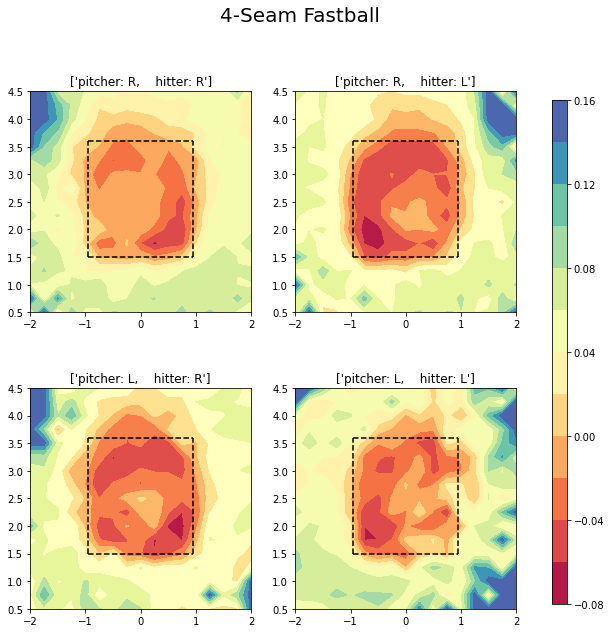

In [22]:
ff_comb_list = [ff_rr, ff_rl, ff_lr, ff_ll]
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
for i in range(4):
    pv_group = ff_comb_list[i].groupby(['plate_x', 'plate_z'])['pitch_value'].mean().reset_index()
    pv_group['pitch_value'] = round(pv_group['pitch_value'],3)

    group_data = pv_group[(pv_group['plate_x']>=-2)&(pv_group['plate_x']<=2)&(pv_group['plate_z']>=0.5)&(pv_group['plate_z']<=4.5)]
    group_data['pitch_value'] = np.where(group_data['pitch_value']>0.15, 0.15, group_data['pitch_value'])
    group_data['pitch_value'] = np.where(group_data['pitch_value']<-0.15, -0.15, group_data['pitch_value'])

    pivot = group_data.pivot(index='plate_z', columns='plate_x', values='pitch_value')
    pivot = pivot.fillna(group_data['pitch_value'].max())
    pivot = pivot.sort_index()

    x = pivot.columns
    y = pivot.index
    z = []
    for j in range(len(pivot)):
        z.append(np.array(pivot.iloc[j]))

    strike_x=[-0.947, 0.947]
    strike_y=[1.5, 3.6]

    ax = plt.subplot(2,2,i+1)
    f = ax.contourf(x, y, z, 10, cmap='Spectral', linestyles='--')
    ax.vlines([min(strike_x),max(strike_x)], min(strike_y), max(strike_y), colors='black', linestyles='--', label='Strike Zone')
    ax.hlines([min(strike_y),max(strike_y)], min(strike_x), max(strike_x), linestyles='--', colors='black')
    plt.title('pitcher: ' + ff_comb_list[i]['p_throws'].unique() +',    hitter: ' + ff_comb_list[i]['stand'].unique())
    plt.gca().set_aspect('equal', adjustable='box')
    
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(f, cax=cbar_ax)
plt.suptitle('4-Seam Fastball', fontsize=20)
plt.show()

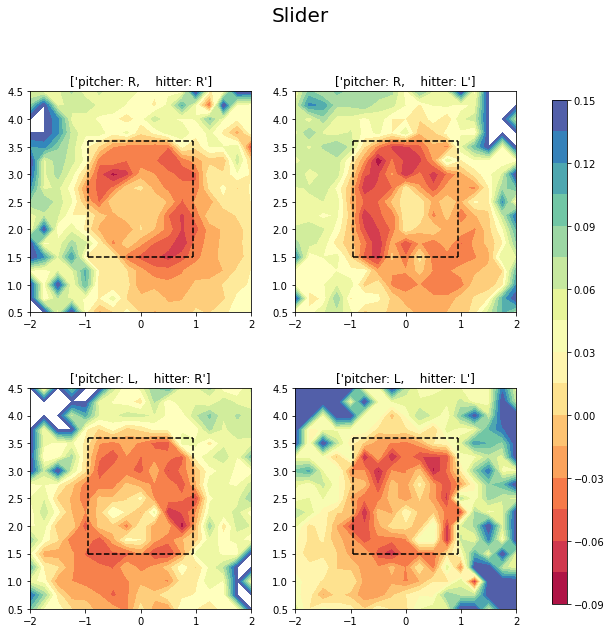

In [23]:
sl_comb_list = [sl_rr, sl_rl, sl_lr, sl_ll]
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
for i in range(4):
    pv_group = sl_comb_list[i].groupby(['plate_x', 'plate_z'])['pitch_value'].mean().reset_index()
    pv_group['pitch_value'] = round(pv_group['pitch_value'],3)

    group_data = pv_group[(pv_group['plate_x']>=-2)&(pv_group['plate_x']<=2)&(pv_group['plate_z']>=0.5)&(pv_group['plate_z']<=4.5)]
    group_data['pitch_value'] = np.where(group_data['pitch_value']>0.15, 0.15, group_data['pitch_value'])
    group_data['pitch_value'] = np.where(group_data['pitch_value']<-0.08, -0.08, group_data['pitch_value'])

    pivot = group_data.pivot(index='plate_z', columns='plate_x', values='pitch_value')
    pivot = pivot.fillna(group_data['pitch_value'].max())
    pivot = pivot.sort_index()

    x = pivot.columns
    y = pivot.index
    z = []
    for j in range(len(pivot)):
        z.append(np.array(pivot.iloc[j]))

    strike_x=[-0.947, 0.947]
    strike_y=[1.5, 3.6]

    ax = plt.subplot(2,2,i+1)
    f = ax.contourf(x, y, z, 20, cmap='Spectral', linestyles='--')
    ax.vlines([min(strike_x),max(strike_x)], min(strike_y), max(strike_y), colors='black', linestyles='--', label='Strike Zone')
    ax.hlines([min(strike_y),max(strike_y)], min(strike_x), max(strike_x), linestyles='--', colors='black')
    plt.title('pitcher: ' + sl_comb_list[i]['p_throws'].unique() +',    hitter: ' + sl_comb_list[i]['stand'].unique())
    plt.gca().set_aspect('equal', adjustable='box')
    
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(f, cax=cbar_ax)
plt.suptitle('Slider', fontsize=20)
plt.show()

In [72]:
starter_pv[starter_pv['player_name']=='Ryu, Hyun Jin']

,player_name,pitch_name,pitch_value_sum,pitch_value_mean,release_speed,count,total,pitch %
1460,"Ryu, Hyun Jin",4-Seam Fastball,-1.6810,-0.0018,89.95,946,2688,35.2
1461,"Ryu, Hyun Jin",Changeup,-0.7456,-0.0011,79.88,684,2688,25.4
1462,"Ryu, Hyun Jin",Curveball,0.6963,0.0021,73.90,338,2688,12.6
1463,"Ryu, Hyun Jin",Cutter,-1.8245,-0.0027,86.29,685,2688,25.5
1464,"Ryu, Hyun Jin",Sinker,2.1098,0.1005,89.25,21,2688,0.8
1465,"Ryu, Hyun Jin",Slider,-0.7627,-0.0545,79.84,14,2688,0.5


In [82]:
starter_date = starter_data.groupby(['game_date', 'player_name', 'pitch_name']).agg({'pitch_value': 'sum', 'release_speed': 'mean', 'pitcher': 'count'}).reset_index().rename(columns={'pitcher': 'count', 'pitch_value': 'pitch_value_sum'})
starter_date_mean = starter_data.groupby(['game_date', 'player_name', 'pitch_name']).agg({'pitch_value': 'mean'}).reset_index().rename(columns={'pitch_value': 'pitch_value_mean'})
starter_date = pd.merge(starter_date, starter_date_mean, on=['game_date', 'player_name', 'pitch_name'])
starter_date['pitch_value_sum'] = round(starter_date['pitch_value_sum'],4)
starter_date['pitch_value_mean'] = round(starter_date['pitch_value_mean'],4)
starter_date['release_speed'] = round(starter_date['release_speed'],2)


starter_total_date = starter_date.groupby(['player_name'])['count'].sum().reset_index().rename(columns={'count': 'total'})
starter_date=pd.merge(starter_date, starter_total_date, on ='player_name')
starter_date['pitch %'] = round(100*starter_date['count']/starter_date['total'],1)
starter_date = starter_date[['game_date', 'player_name', 'pitch_name', 'pitch_value_sum', 'pitch_value_mean', 'release_speed', 'count', 'total', 'pitch %']]

In [107]:
ohtani = starter_date[starter_date['player_name']=='Ohtani, Shohei']

,game_date,player_name,pitch_name,pitch_value_sum,pitch_value_mean,release_speed,count,total,pitch %
17367,2021-04-04,"Ohtani, Shohei",4-Seam Fastball,-0.5692,-0.0107,97.96,53,2024,2.6
17368,2021-04-04,"Ohtani, Shohei",Curveball,0.0699,0.0350,75.50,2,2024,0.1
17369,2021-04-04,"Ohtani, Shohei",Cutter,-0.0646,-0.0646,90.30,1,2024,0.0
17370,2021-04-04,"Ohtani, Shohei",Slider,-0.1037,-0.0049,81.57,21,2024,1.0
17371,2021-04-04,"Ohtani, Shohei",Split-Finger,-0.6574,-0.0438,90.27,15,2024,0.7
...,...,...,...,...,...,...,...,...,...
17466,2021-09-19,"Ohtani, Shohei",Split-Finger,-4.6733,-0.0850,89.22,55,2024,2.7
17467,2021-09-26,"Ohtani, Shohei",4-Seam Fastball,-0.7698,-0.0367,97.45,21,2024,1.0
17468,2021-09-26,"Ohtani, Shohei",Cutter,-0.0034,-0.0008,86.12,4,2024,0.2
17469,2021-09-26,"Ohtani, Shohei",Slider,-2.1115,-0.0406,84.58,52,2024,2.6


In [83]:
ryu = starter_date[starter_date['player_name']=='Ryu, Hyun Jin']
ryu

,game_date,player_name,pitch_name,pitch_value_sum,pitch_value_mean,release_speed,count,total,pitch %
5131,2021-04-01,"Ryu, Hyun Jin",4-Seam Fastball,0.4355,0.0168,89.93,26,2688,1.0
5132,2021-04-01,"Ryu, Hyun Jin",Changeup,-1.7574,-0.0533,79.97,33,2688,1.2
5133,2021-04-01,"Ryu, Hyun Jin",Curveball,-0.2178,-0.0311,73.63,7,2688,0.3
5134,2021-04-01,"Ryu, Hyun Jin",Cutter,0.5762,0.0222,85.94,26,2688,1.0
5135,2021-04-07,"Ryu, Hyun Jin",4-Seam Fastball,0.6466,0.0340,90.06,19,2688,0.7
...,...,...,...,...,...,...,...,...,...
5260,2021-09-28,"Ryu, Hyun Jin",Sinker,2.1287,0.2365,91.47,9,2688,0.3
5261,2021-10-03,"Ryu, Hyun Jin",4-Seam Fastball,-0.3389,-0.0106,90.60,32,2688,1.2
5262,2021-10-03,"Ryu, Hyun Jin",Changeup,-1.2856,-0.0476,81.06,27,2688,1.0
5263,2021-10-03,"Ryu, Hyun Jin",Curveball,-0.0412,-0.0041,75.33,10,2688,0.4


In [108]:
ryu['month'] = ryu['game_date'].str[5:]
ohtani['month'] = ohtani['game_date'].str[5:]

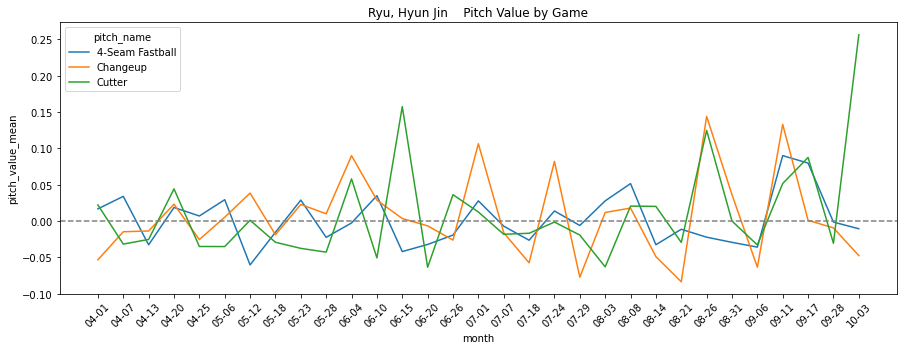

In [105]:
plt.figure(figsize=(15,5))
sns.lineplot(data=ryu[(ryu['pitch_name']=='4-Seam Fastball')|(ryu['pitch_name']=='Cutter')|(ryu['pitch_name']=='Changeup')], x='month', y='pitch_value_mean', hue='pitch_name')
plt.xticks(rotation=45)
plt.axhline(color='grey', linestyle='--')
plt.title('Ryu, Hyun Jin    Pitch Value by Game')
plt.show()

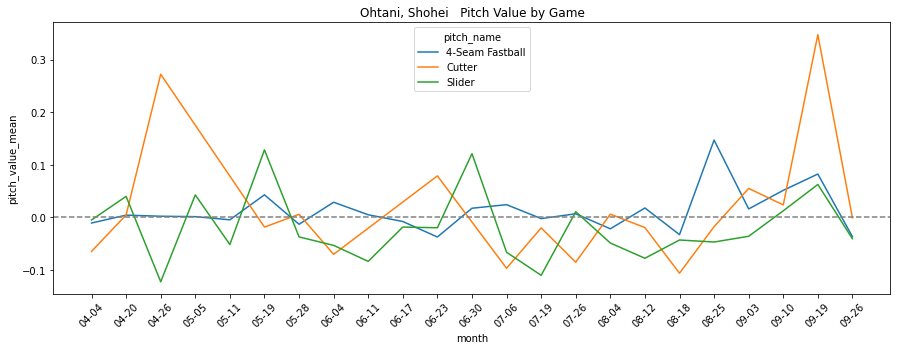

In [114]:
plt.figure(figsize=(15,5))
sns.lineplot(data=ohtani[(ohtani['pitch_name']=='4-Seam Fastball')|(ohtani['pitch_name']=='Slider')|(ohtani['pitch_name']=='Cutter')], x='month', y='pitch_value_mean', hue='pitch_name')
plt.xticks(rotation=45)
plt.axhline(color='grey', linestyle='--')
plt.title('Ohtani, Shohei   Pitch Value by Game')
plt.show()